In this notebook, we show how to estimate the sky surface brightness (sky-SB) using the methods from [O'Brien et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv221008010O/abstract).

## Imports

In [1]:
# Sky-SB codes
from skysurf_estimate_sky import calculate_sky
from make_diagnostic import make_plots

# For downloading test data
from astropy.io import fits
from astroquery.mast import Observations

# Other
from glob import glob
import pandas as pd
import os

## Download test data

We download some test data to estimate the sky-SB. We choose images of the [JWST NEP TDF](http://lambda.la.asu.edu/jwst/neptdf/), taken with the ACS/WFC camera on the Hubble Space Telescope, using the F606W filter. We will estimate the sky-SB directly on flc images, which are calibrated HST images.

In [2]:
# ### Query observations ###
obs_table = Observations.query_criteria(proposal_pi="Jansen*", proposal_id = 15278, filters = 'F606W')
data_products = Observations.get_product_list(obs_table)

### Download FLC files ###
data_flc = data_products[(data_products['productSubGroupDescription'] == 'FLC') & (data_products['type'] == 'S')]
Observations.download_products(data_flc[:10]) # Only download the first few images

We define the list of files we will be working with, which are located in the 'mastDownload' directory.

In [3]:
file_list = glob('mastDownload/HST/*/*_flc.fits')
file_list

['mastDownload/HST/jdkq01d9q/jdkq01d9q_flc.fits',
 'mastDownload/HST/jdkq01cwq/jdkq01cwq_flc.fits',
 'mastDownload/HST/jdkq01cyq/jdkq01cyq_flc.fits',
 'mastDownload/HST/jdkq01d7q/jdkq01d7q_flc.fits',
 'mastDownload/HST/jdkq01diq/jdkq01diq_flc.fits']

## Estimate sky-SB

To estimate the sky-SB from a single image, we choose one of the files in 'file_list' defined above.

In [4]:
file = file_list[0]

We open this FITS file and read the science and data quality (DQ) extensions. The science extension contains the real image, while DQ flags indicate pixels that can be unreliable, including pixels contaminated with cosmic rays, saturated pixels, or known bad detector pixels. The DQ data is used to mask unreliable pixels during sky-SB estimation.

In [5]:
# Open the fits file
hdu = fits.open(file)

# Open the science data
sci1_data = hdu['SCI', 1].data

# Open the data quality data
dq1_data = hdu['DQ', 1].data

Next, we use the function 'calculate_sky' to estimate the sky-SB. We give the 'calculate_sky' function the science array, the DQ array, and the size of a sub-region.

The 'bin_size' is the size of each sub-region in pixel units, where the image is divided into sub-regions of this size to estimate the sky-SB. Bigger sub-regions make it harder to mask unreliable sub-regions, but too small of a sub-region lacks sufficient statistics for a robust sky measurement within a single sub-region. In [O'Brien et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv221008010O/abstract), we use box sizes of 39x39 pixels for WFC3/IR and 64x64 pixels for ACS/WFC and WFC3/UVIS. Note that any leftover pixels after creating these sub-regions are added to the top-most and right-most sub-regions.

We set has_DQ = True when we want to mask pixels flagged in the DQ extension. The 'dq_fraction' parameter defines the fraction of pixels in a single-subregion that must be flagged in the DQ array for the entire sub-region to be ignored. We set this value to 0.2, or if more than 20% of the pixels in a sub-region are flagged, this sub-region is ignored.

In [6]:
sky_dic1 = calculate_sky(sci1_data, bin_size = 64, dq_data = dq1_data, has_DQ = True, dq_fraction = 0.2,
                         percentile = 50)

The calculate_sky function returns a dictionary containing information about the sky-SB calculation.

| Parameter | Definition |
| -- | -- |
| calc_sky | The calculated sky-SB in the native units of the image
| calc_rms | The calculated sky-SB rms in the native units of the image
| N_total_regions | Number of sub-regions
| N_bad_regions | Number of sub-regions where the algorithm detected an object
| N_bad_px_regions | Number of sub-regions where the number of DQ-flagged pixels is greater than 20%
| N_good_regions | Number of sub-regions used to calculated calc_sky and calc_rms
| calc_sky_mean | Same as calc_sky, but using a mean instead of a median during the iterative clipping
| calc_rms_mean | Same as calc_rms, but using a mean instead of a median during the iterative clipping
| sky_arr | Array containing all sky levels corresponding to individual sub-regions (used for creating plots)
| rms_arr | Array containing all sky rms levels corresponding to individual sub-regions (used for creating plots)
| cutouts | List of Cutout2D objects corresponding to each sub-region (used for creating plots)
| lowest5perc_ind | Indices corresponding to the darkest 5% of sub-regions (used for creating plots)
| bad_ind | Indices corresponding to sub-regions where the algorithm detected an object (used for creating plots)
| badpx_ind | Indices corresponding to sub-regions where the number of DQ-flagged pixels is greater than 20% (used for creating plots)
| mean_x_pos and mean_y_pos | Mean x/y position of all "good" sub-regions
| std_x_pos and std_y_pos | Standard deviation of all "good" sub-regions

## Plot results

Next, we plot the image with the sub-regions overlayed to ensure the algorithm performed correctly. Information about the image is displayed underneath the figure, including the measured sky-SB, the measured sky-SB rms, and the fraction of sub-regions (F) that are flagged.

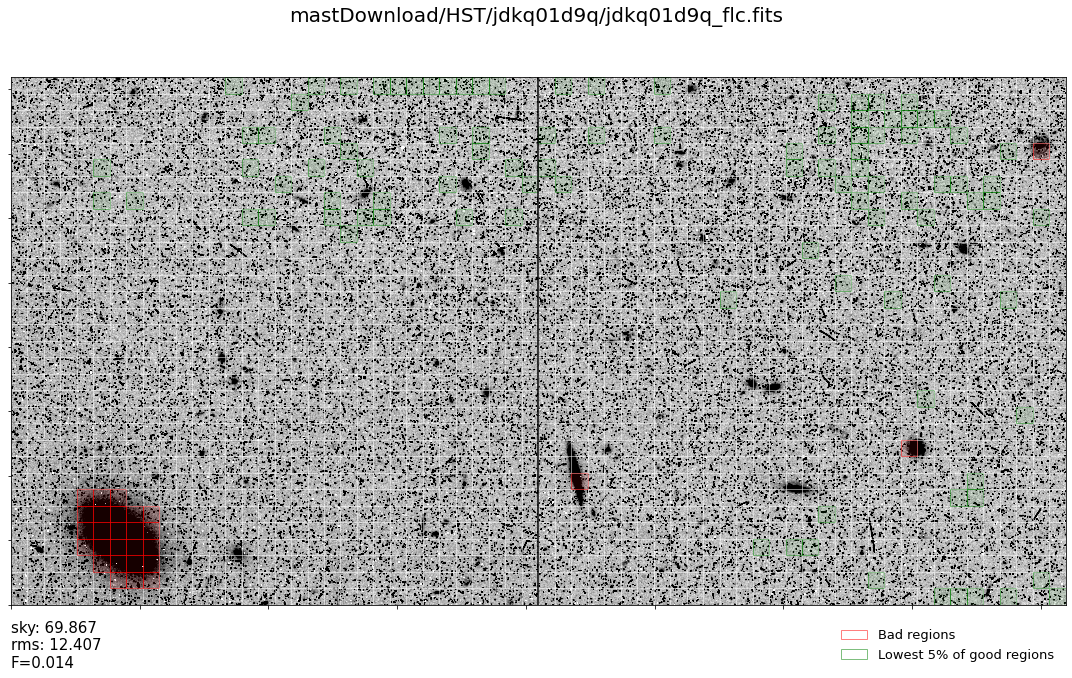

In [7]:
make_plots(data = sci1_data, cutouts = sky_dic1['cutouts'][0], 
           goodind = sky_dic1['lowest5perc_ind'][0], badind = sky_dic1['bad_ind'][0], 
           sky = sky_dic1['calc_sky'][0], rms = sky_dic1['calc_rms'][0], 
           badpx = sky_dic1['badpx_ind'][0], title = file_list[0], 
           save = False, savepath = None, 
           show = True, figsize = (15,9))

## Run on multiple images

To run calculate_sky on multiple images, we will loop through all the files and save the information to a pandas dataframe.

In [8]:
df = pd.DataFrame([])

for file in file_list:
    
    for sci_ext in [1,2]:
        
        print(file, 'SCI'+str(sci_ext))
    
        # Make small dataframe with file name
        root = os.path.basename(file).split('_')[0]
        file_df = pd.DataFrame({'file': [file], 'root': [root], 'sci_ext': [sci_ext]})

        # Open the fits file
        hdu = fits.open(file)

        # Save the science data
        sci_data = hdu['SCI', sci_ext].data

        # Save the data quality data
        dq_data = hdu['DQ', sci_ext].data

        sky_dic = calculate_sky(sci_data, bin_size = 64, dq_data = dq_data, has_DQ = True, dq_fraction = 0.2)
        
        ### Make plots ###
        # Instead of showing each figure, save them in the local directory
        save_images = '{r}_percentileclip_sky_SCI{e}.png'.format(r = root, e = sci_ext)
        title = file+'\nExt. {}'.format(sci_ext)
        make_plots(data = sci_data, cutouts = sky_dic['cutouts'][0], 
               goodind = sky_dic['lowest5perc_ind'][0], badind = sky_dic['bad_ind'][0], 
               sky = sky_dic['calc_sky'][0], rms = sky_dic['calc_rms'][0], 
               badpx = sky_dic['badpx_ind'][0], title = title, 
               save = True, savepath = save_images, 
               show = False, figsize = (15,9))

        ### Drop keys from output that we no longer need ###
        drop_keys = ['sky_arr', 'rms_arr', 'cutouts', 'lowest5perc_ind', 'bad_ind', 'badpx_ind']
        for key in drop_keys:
            sky_dic.pop(key, None)

        ### Save information to dataframe ###
        tempdf = pd.DataFrame(pd.concat([file_df, pd.DataFrame(sky_dic)], axis = 1))

        df = pd.concat([df, tempdf])

mastDownload/HST/jdkq01d9q/jdkq01d9q_flc.fits SCI1
mastDownload/HST/jdkq01d9q/jdkq01d9q_flc.fits SCI2
mastDownload/HST/jdkq01cwq/jdkq01cwq_flc.fits SCI1
mastDownload/HST/jdkq01cwq/jdkq01cwq_flc.fits SCI2
mastDownload/HST/jdkq01cyq/jdkq01cyq_flc.fits SCI1
mastDownload/HST/jdkq01cyq/jdkq01cyq_flc.fits SCI2
mastDownload/HST/jdkq01d7q/jdkq01d7q_flc.fits SCI1
mastDownload/HST/jdkq01d7q/jdkq01d7q_flc.fits SCI2
mastDownload/HST/jdkq01diq/jdkq01diq_flc.fits SCI1
mastDownload/HST/jdkq01diq/jdkq01diq_flc.fits SCI2


In [9]:
df

,file,root,sci_ext,calc_sky,calc_rms,N_total_regions,N_bad_regions,N_bad_px_regions,N_good_regions,calc_sky_mean,calc_rms_mean,mean_x_pos,mean_y_pos,std_x_pos,std_y_pos
0,mastDownload/HST/jdkq01d9q/jdkq01d9q_flc.fits,jdkq01d9q,1,69.867401,12.407145,2048,28,0,2020,70.091766,12.394600,2066.376238,1033.568317,1175.168963,588.288455
0,mastDownload/HST/jdkq01d9q/jdkq01d9q_flc.fits,jdkq01d9q,2,69.806625,12.601590,2048,22,0,2026,70.040436,12.598823,2057.571570,1020.430405,1181.734229,589.598733
0,mastDownload/HST/jdkq01cwq/jdkq01cwq_flc.fits,jdkq01cwq,1,211.163399,17.296380,2048,22,0,2026,211.492744,17.296380,2063.415597,1031.897335,1176.855008,589.096953
0,mastDownload/HST/jdkq01cwq/jdkq01cwq_flc.fits,jdkq01cwq,2,208.003754,17.467857,2048,14,0,2034,208.385834,17.459225,2053.506391,1021.734513,1181.860945,589.729865
0,mastDownload/HST/jdkq01cyq/jdkq01cyq_flc.fits,jdkq01cyq,1,63.309521,11.871413,2048,26,0,2022,63.524082,11.862055,2064.807122,1032.767557,1175.647436,588.561656
0,mastDownload/HST/jdkq01cyq/jdkq01cyq_flc.fits,jdkq01cyq,2,63.233440,12.063055,2048,22,0,2026,63.438480,12.061082,2057.571570,1020.430405,1181.734229,589.598733
0,mastDownload/HST/jdkq01d7q/jdkq01d7q_flc.fits,jdkq01d7q,1,157.076706,15.727658,2048,27,16,2005,157.350464,15.725952,2049.611970,1039.561097,1170.936173,587.096603
0,mastDownload/HST/jdkq01d7q/jdkq01d7q_flc.fits,jdkq01d7q,2,155.336273,15.902166,2048,19,0,2029,155.632126,15.896254,2055.775259,1021.271562,1181.957390,589.651382
0,mastDownload/HST/jdkq01diq/jdkq01diq_flc.fits,jdkq01diq,1,150.359665,15.479724,2048,24,0,2024,150.626831,15.479724,2063.747036,1032.474308,1176.666504,589.100926
0,mastDownload/HST/jdkq01diq/jdkq01diq_flc.fits,jdkq01diq,2,149.205139,15.713936,2048,17,0,2031,149.511887,15.704157,2054.790743,1020.801576,1181.818697,589.554488


Finally, we save all sky measurements into a single CSV file.

In [10]:
df.to_csv('percentileclip_sky_jwstneptdf.csv', index = False)